## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 1)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

> Implementation is from [base_example_to_try_different_implementations/from_deeponet-fno.ipynb](../../../base_example_to_try_different_implementations/from_deeponet-fno.ipynb) which is based on [deeponet-fno/src/darcy_triangular_notch
/deeponet](https://github.com/lu-group/deeponet-fno/tree/main/src/darcy_triangular_notch/deeponet) of [deeponet-fno](https://github.com/lu-group/deeponet-fno/tree/main) library. It uses `tensorflow.compat.v1`.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement1/neural_operator_prediction_comparison.png" width="800"> </p>

In [1]:
import sys
import os
import time

# os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

import numpy as np
import scipy
import scipy.io as io

import dolfin as dl

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

2024-11-08 14:49:27.673370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 14:49:27.694267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 14:49:27.700889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 14:49:27.716616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement1/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Data related methods

In [3]:
class DataProcessor:
    def __init__(self, batch_size, num_train = 1900, num_test = 100, \
                 num_inp_fn_points = 2601, num_out_fn_points = 2601):
        self.batch_size = batch_size
        self.num_train = num_train
        self.num_test = num_test
        self.num_inp_fn_points = num_inp_fn_points
        self.num_out_fn_points = num_out_fn_points

        self.data, self.X_trunk, self.X_train, self.Y_train, \
            self.X_test, self.Y_test, self.X_train_mean, \
            self.X_train_std, self.Y_train_mean, self.Y_train_std, \
            self.tol = self.load_data()

        self.X_trunk_min = np.min(self.X_trunk, axis = 0)
        self.X_trunk_max = np.max(self.X_trunk, axis = 0)
    
    def load_data(self, tol = 1.0e-9):
        
        data = np.load(data_folder + 'Poisson_samples.npz')

        # trunk input data ('xi' coordinates)
        X_trunk = data['u_mesh_nodes']
        
        # branch input data ('m' functions)
        X_train = data['m_samples'][:self.num_train,:]
        X_test = data['m_samples'][self.num_train:(self.num_train + self.num_test),:]

        X_train_mean = np.mean(np.reshape(X_train, (-1, self.num_inp_fn_points)), 0)
        X_train_mean = np.reshape(X_train_mean, (-1, 1, self.num_inp_fn_points))

        X_train_std = np.std(np.reshape(X_train, (-1, self.num_inp_fn_points)), 0)
        X_train_std = np.reshape(X_train_std, (-1, 1, self.num_inp_fn_points))

        X_train = np.reshape(X_train, (-1, 1, self.num_inp_fn_points))
        X_train = (X_train - X_train_mean)/(X_train_std + tol)

        X_test = np.reshape(X_test, (-1, 1, self.num_inp_fn_points))
        X_test = (X_test - X_train_mean)/(X_train_std + tol)

        # output data ('u' functions)
        Y_train = data['u_samples'][:self.num_train,:]
        Y_test = data['u_samples'][self.num_train:(self.num_train + self.num_test),:]
        
        Y_train_mean = np.mean(np.reshape(Y_train, (-1, self.num_out_fn_points)), 0)
        Y_train_mean = np.reshape(Y_train_mean, (-1, self.num_out_fn_points, 1))

        Y_train_std = np.std(np.reshape(Y_train, (-1, self.num_out_fn_points)), 0)
        Y_train_std = np.reshape(Y_train_std, (-1, self.num_out_fn_points, 1))

        Y_train = np.reshape(Y_train, (-1, self.num_out_fn_points, 1))
        Y_train = (Y_train - Y_train_mean)/(Y_train_std + tol)
        
        Y_test = np.reshape(Y_test, (-1, self.num_out_fn_points, 1))
        Y_test = (Y_test - Y_train_mean)/(Y_train_std + tol)
        
        return data, X_trunk, X_train, Y_train, X_test, Y_test, X_train_mean, X_train_std, Y_train_mean, Y_train_std, tol
        
    def minibatch(self):

        batch_id = np.random.choice(self.X_train.shape[0], self.batch_size, replace=False)

        X_train = [self.X_train[i:i+1] for i in batch_id]
        X_train = np.concatenate(X_train, axis=0)
        Y_train = [self.Y_train[i:i+1] for i in batch_id]
        Y_train = np.concatenate(Y_train, axis=0)

        X_trunk_train = self.X_trunk
        X_trunk_min = self.X_trunk_min
        X_trunk_max = self.X_trunk_max

        return X_train, X_trunk_train, Y_train, X_trunk_min, X_trunk_max

    def testbatch(self, num_test):
        batch_id = np.arange(num_test)
        X_test = [self.X_test[i:i+1] for i in batch_id]
        X_test = np.concatenate(X_test, axis=0)
        Y_test = [self.Y_test[i:i+1] for i in batch_id]
        Y_test = np.concatenate(Y_test, axis=0)
        X_trunk_test = self.X_trunk

        return X_test, X_trunk_test, Y_test
    
    def encoder_Y(self, x):
        x = (x - self.Y_train_mean)/(self.Y_train_std + self.tol)
        return x
    
    def encoder_Y_1d(self, x):    
        x[:] = (x[:] - self.Y_train_mean[0,:,0])/(self.Y_train_std[0,:,0] + self.tol)
        return x

    def decoder_Y(self, x):
        x = x*(self.Y_train_std + self.tol) + self.Y_train_mean
        return x
    
    def decoder_Y_1d(self, x):
        # assume x is 1D array
        x[:] = x[:]*(self.Y_train_std[0,:,0] + self.tol) + self.Y_train_mean[0,:,0]
        return x
    
    def encoder_X(self, x):
        x = (x - self.X_train_mean)/(self.X_train_std + self.tol)
        return x
    
    def encoder_X_1d(self, x):    
        x[:] = (x[:] - self.X_train_mean[0,:,0])/(self.X_train_std[0,:,0] + self.tol)
        return x
    
    def decoder_X(self, x):
        x = x*(self.X_train_std + self.tol) + self.X_train_mean
        return x
    
    def decoder_X_1d(self, x):
        # assume x is 1D array
        x[:] = x[:]*(self.X_train_std[0,:,0] + self.tol) + self.X_train_mean[0,:,0]
        return x

In [4]:
class SaveData:
    def __init__(self):
        pass

    def save(self, sess, X_trunk_pos, fnn_model, W_T, b_T, W_B, b_B, X_trunk_min, X_trunk_max, X_ph, Y_ph, data, num_test, results_dir):
        
        X_test, X_trunk_test, Y_test = data.testbatch(num_test)
        X_trunk = tf.tile(X_trunk_pos[None, :, :], [num_test, 1, 1])
        u_T = fnn_model.fnn_T(W_T, b_T, X_trunk, X_trunk_min, X_trunk_max)
        test_dict = {X_ph: X_test, Y_ph: Y_test}
        u_B = fnn_model.fnn_B(W_B, b_B, X_ph)
        u_B = tf.tile(u_B, [1, X_trunk_test.shape[0], 1])
        u_nn = u_B*u_T
        Y_pred = tf.reduce_sum(u_nn, axis=-1, keepdims=True)
        Y_pred_ = sess.run(Y_pred, feed_dict=test_dict)
        Y_test = data.decoder_Y(Y_test)
        Y_pred_ = data.decoder_Y(Y_pred_)   

        X_test = np.reshape(X_test, (X_test.shape[0], -1))
        Y_pred_ = np.reshape(Y_pred_, (Y_test.shape[0], Y_test.shape[1]))        
        Y_ref = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1]))

        err = np.mean(np.linalg.norm(Y_pred_ - Y_ref, 2, axis=1)/np.linalg.norm(Y_ref, 2, axis=1))
        print('Relative L2 Error: %.3f'%(err))
        err = np.reshape(err, (-1, 1))
        
        np.savetxt(results_dir+'/err.txt', err, fmt='%e')
        
        scipy.io.savemat(results_dir+'Poisson_DeepONet.mat', 
                     mdict={'X_test': X_test,
                            'Y_test': Y_test, 
                            'Y_pred': Y_pred_})
        

## Define network methods

In [5]:
class FNN:
    def __init__(self):
        pass
    
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2./(in_dim + out_dim))
            weight = tf.Variable(tf.random_normal(shape=[in_dim, out_dim], stddev=std))
            bias = tf.Variable(tf.zeros(shape=[1, out_dim]))
            W.append(weight)
            b.append(bias)

        return W, b

    def fnn_T(self, W, b, X, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        L = len(W)
        for i in range(L-1):
            A = tf.nn.leaky_relu(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y
    
    def fnn_B(self, W, b, X):
        A = X
        L = len(W)
        for i in range(L-1):
            A = tf.nn.leaky_relu(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y

## Load data

In [6]:
num_train = 1900
num_test = 100

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_br_tr_outputs = 100 # number of outputs from the branch and trunk networks before they are multiplied

#branch net
layer_B = [num_inp_fn_points, 128, 128, num_br_tr_outputs]
#trunk net
layer_T = [2, 128, 128, num_br_tr_outputs]

#batch_size
batch_size = 100
epochs = 1000
lr = 1.0e-3

data = DataProcessor(batch_size, num_train = num_train, num_test = num_test, num_inp_fn_points = num_inp_fn_points, num_out_fn_points = num_out_fn_points)

## Create model and train the network

In [ ]:
X_train, X_trunk_train, Y_train, X_trunk_min, X_trunk_max = data.minibatch()
X_trunk_pos = tf.constant(X_trunk_train, dtype=tf.float32)
X_trunk_tf = tf.tile(X_trunk_pos[None, :, :], [batch_size, 1, 1]) #[bs, x_num, x_dim]

X_ph = tf.placeholder(shape=[None, 1, num_inp_fn_points], dtype=tf.float32) #[bs, f_dim]
Y_ph = tf.placeholder(shape=[None, num_out_fn_points, 1], dtype=tf.float32) #[bs, x_num, 1]

learning_rate = tf.placeholder(tf.float32, shape=[])

fnn_model = FNN()

# Branch net
W_B, b_B = fnn_model.hyper_initial(layer_B)
u_B = fnn_model.fnn_B(W_B, b_B, X_ph)
u_B = tf.tile(u_B, [1, num_out_fn_points, 1])   
print('u_B shape:', u_B.shape)

#Trunk net
W_T, b_T = fnn_model.hyper_initial(layer_T)
u_T = fnn_model.fnn_T(W_T, b_T, X_trunk_tf, X_trunk_min, X_trunk_max)
print('u_T shape:', u_T.shape)

#inner product
u_nn = u_B*u_T
print('u_nn shape:', u_nn.shape)

Y_pred = tf.reduce_sum(u_nn, axis=-1, keepdims=True)
print('Y_pred shape:', Y_pred.shape)

u_B shape: (?, 2601, 100)
u_T shape: (100, 2601, 100)
u_nn shape: (100, 2601, 100)
Y_pred shape: (100, 2601, 1)


In [9]:
# loss function 
loss = tf.reduce_mean(tf.square(Y_ph - Y_pred))
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
saver = tf.train.Saver()
sess = tf.Session()  
sess.run(tf.global_variables_initializer())

# verify the error calculation
X_train, X_trunk_train, Y_train, _, _ = data.minibatch()
train_dict={X_ph: X_train, Y_ph: Y_train, learning_rate: lr}
loss_ = sess.run(loss, feed_dict=train_dict)

Y_train_ = sess.run(Y_pred, feed_dict={X_ph: X_train})
err = np.mean(np.square(Y_train_ - Y_train))

print('='*30)
print('Train Loss (l2 squared): {:.3e}, Train Loss (l2 squared): {:.3e}'.format(loss_, err))
print('='*30)


I0000 00:00:1731102919.957635  289833 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731102919.957908  289833 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731102919.958118  289833 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731102919.958400  289833 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Train Loss (l2 squared): 7.917e-01, Train Loss (l2 squared): 7.917e-01


In [ ]:
# begin training
n = 0
start_time = time.perf_counter()

train_loss = np.zeros((epochs+1, 1))
test_loss = np.zeros((epochs+1, 1))    

loss_print_freq = 100

while n <= epochs:

    if n < 1000:
        lr = 0.001
    elif n < 5000:
        lr = 0.0005
    else:
        lr = 0.0001
            
    start_time = time.perf_counter()
    
    # network training
    X_train, X_trunk_train, Y_train, _, _ = data.minibatch()
    train_dict={X_ph: X_train, Y_ph: Y_train, learning_rate: lr}
    loss_, _ = sess.run([loss, train], feed_dict=train_dict)
    
    # network testing
    X_test, X_trunk_test, Y_test = data.testbatch(batch_size)
    Y_test_ = sess.run(Y_pred, feed_dict={X_ph: X_test})
    # Y_test = data.decoder_Y(Y_test)
    # Y_test_ = data.decoder_Y(Y_test_)
    
    # testing error
    err = np.mean(np.square(Y_test_ - Y_test))
    
    end_time = time.perf_counter()

    epoch_time = end_time - start_time

    if n % loss_print_freq == 0:
        print('='*30)
        print('Epoch: {:5d}, Train Loss (l2 squared): {:.3e}, Test Loss (l2 squared): {:.3e}, Time (sec): {:.3f}'.format(n, loss_, err, epoch_time))
        print('='*30)

    train_loss[n,0] = loss_
    test_loss[n,0] = err
    n += 1

Epoch:     0, Train Loss (l2 squared): 9.206e-01, Test Loss (l2 squared): 6.903e+00, Time (sec): 0.385
Epoch:   100, Train Loss (l2 squared): 2.708e-01, Test Loss (l2 squared): 3.430e-01, Time (sec): 0.042
Epoch:   200, Train Loss (l2 squared): 1.338e-01, Test Loss (l2 squared): 1.433e-01, Time (sec): 0.041
Epoch:   300, Train Loss (l2 squared): 8.828e-02, Test Loss (l2 squared): 1.109e-01, Time (sec): 0.042
Epoch:   400, Train Loss (l2 squared): 1.101e-01, Test Loss (l2 squared): 1.030e-01, Time (sec): 0.041
Epoch:   500, Train Loss (l2 squared): 9.825e-02, Test Loss (l2 squared): 9.912e-02, Time (sec): 0.041
Epoch:   600, Train Loss (l2 squared): 1.111e-01, Test Loss (l2 squared): 1.198e-01, Time (sec): 0.041
Epoch:   700, Train Loss (l2 squared): 8.856e-02, Test Loss (l2 squared): 9.622e-02, Time (sec): 0.040
Epoch:   800, Train Loss (l2 squared): 8.785e-02, Test Loss (l2 squared): 9.545e-02, Time (sec): 0.041
Epoch:   900, Train Loss (l2 squared): 1.086e-01, Test Loss (l2 squared):

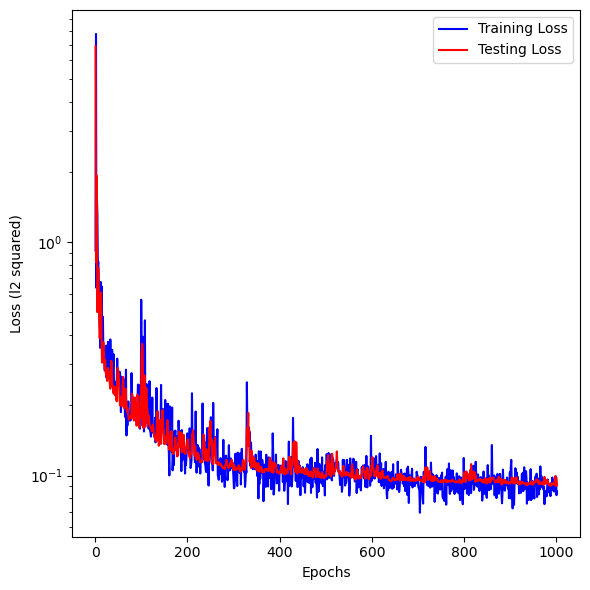

In [11]:
## Plotting the loss history
num_epoch = train_loss.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, train_loss[:,0], color='blue', label='Training Loss')
ax.plot(x, test_loss[:,0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

In [12]:
save_models_to = results_dir +"model/"
if not os.path.exists(save_models_to):
    os.makedirs(save_models_to)      

saver.save(sess, save_models_to+'Model')

np.savetxt(results_dir+'/train_loss.txt', train_loss)
np.savetxt(results_dir+'/test_loss.txt', test_loss)

data_save = SaveData()
data_save.save(sess, X_trunk_pos, fnn_model, W_T, b_T, W_B, b_B, X_trunk_min, X_trunk_max, X_ph, Y_ph, data, num_test, results_dir)

Relative L2 Error: 0.055


## Test and plot the output of network

In [13]:
X_test, X_trunk_test, Y_test = data.testbatch(batch_size)
Y_test_pred = sess.run(Y_pred, feed_dict={X_ph: X_test})

error = np.mean(np.linalg.norm(Y_test_pred - Y_test, 2, axis=1)/np.linalg.norm(Y_test, 2, axis=1))

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 2601, 1), test_pred shape: (100, 2601, 1)
Num tests:   100, Mean Loss (rel l2): 3.925e-01, Std Loss (rel l2): 0.000e+00


In [14]:
def get_FE_space(mesh_file = data_folder + 'Poisson_u_mesh.xdmf'):
    mesh = dl.Mesh()
    with dl.XDMFFile(mesh_file) as infile:
        infile.read(mesh)
    V = dl.FunctionSpace(mesh, "Lagrange", 1)
    return V

i_plot =     0, error (rel l2): 1.885e-02
i_plot =     1, error (rel l2): 1.170e-02
i_plot =     2, error (rel l2): 4.480e-02
i_plot =     3, error (rel l2): 3.767e-02
i_plot =     4, error (rel l2): 4.671e-02
i_plot =     5, error (rel l2): 5.562e-02
i_plot =     6, error (rel l2): 1.209e-01
i_plot =     7, error (rel l2): 1.122e-01
i_plot =     8, error (rel l2): 3.304e-02
i_plot =     9, error (rel l2): 2.124e-02
i_plot =    10, error (rel l2): 4.282e-02
i_plot =    11, error (rel l2): 2.747e-02
i_plot =    12, error (rel l2): 1.853e-02
i_plot =    13, error (rel l2): 2.142e-02
i_plot =    14, error (rel l2): 2.308e-02
i_plot =    15, error (rel l2): 5.930e-02


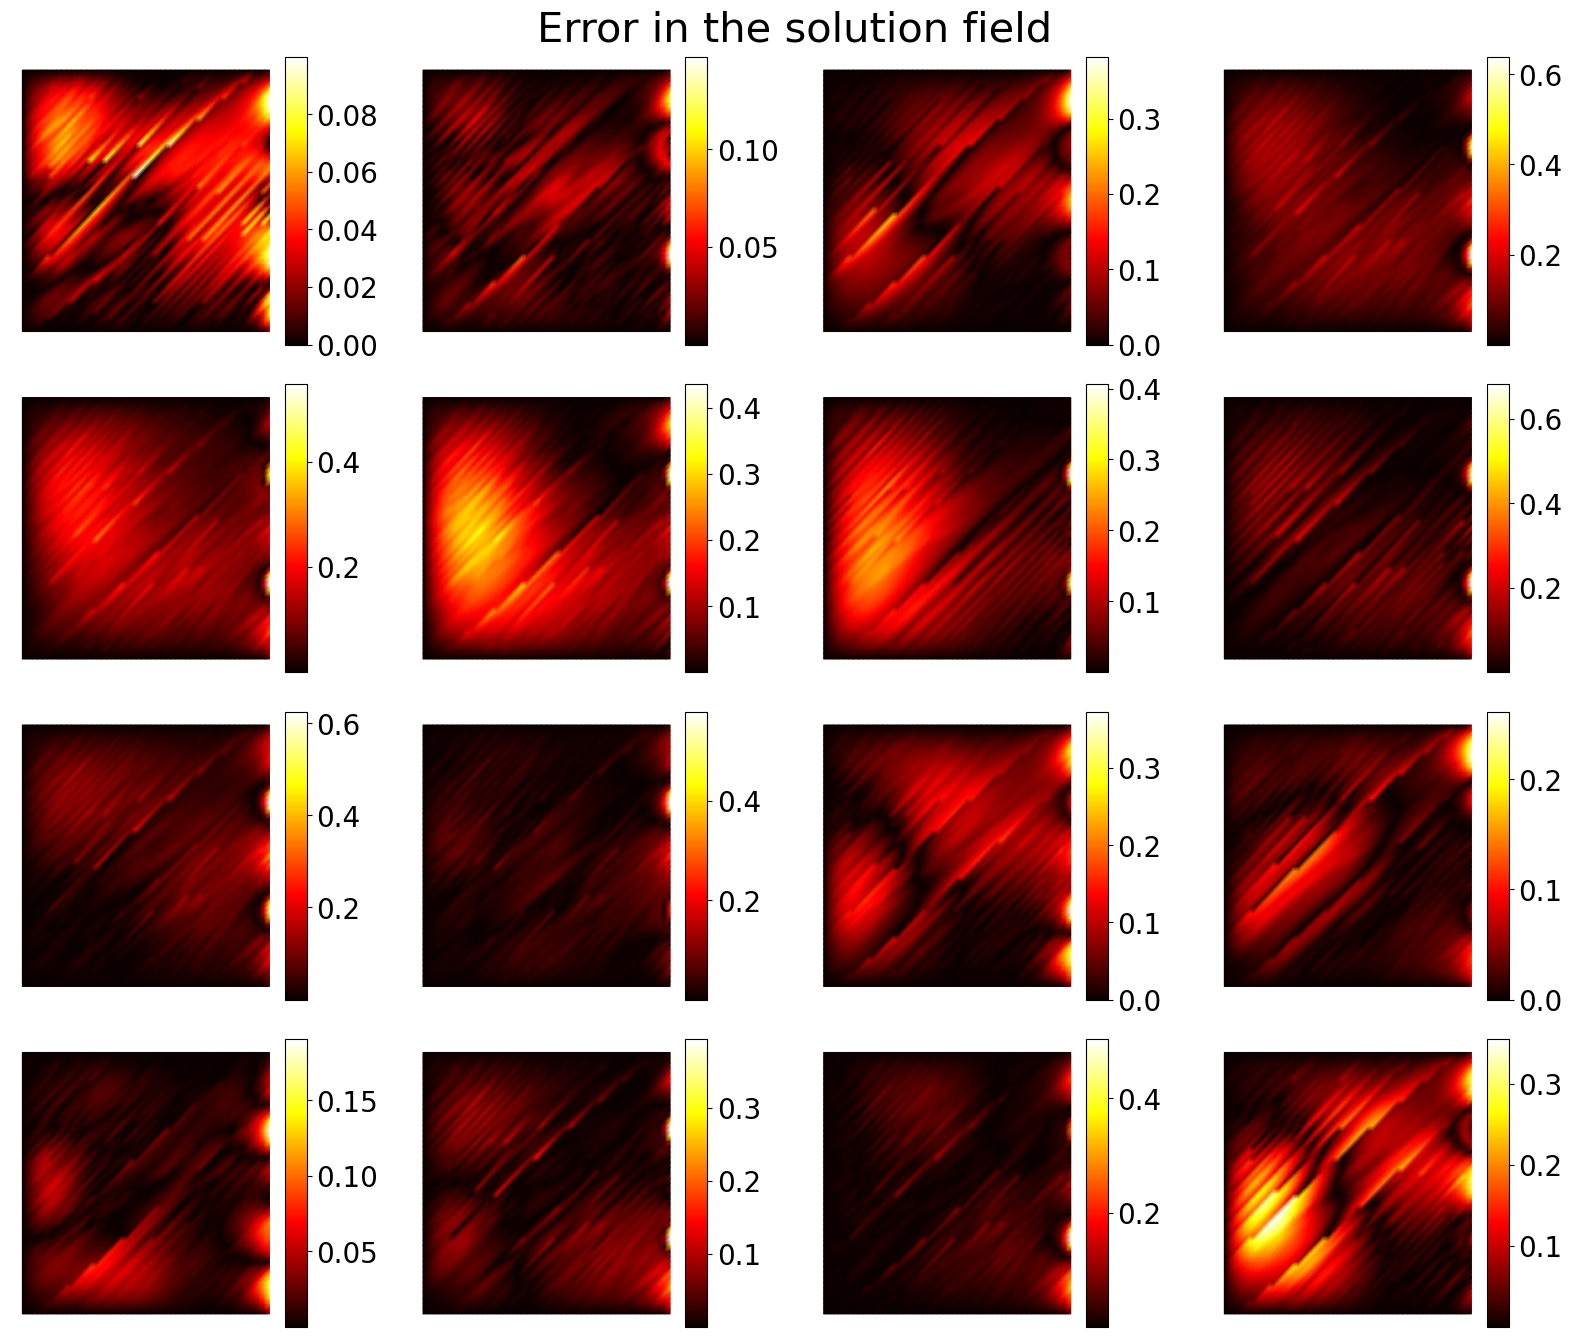

In [15]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + 'Poisson_u_mesh.xdmf')
Vm = get_FE_space(data_folder + 'Poisson_m_mesh.xdmf')

Y_spatial_points = data.X_trunk

for i in range(rows):
    for j in range(cols):
        i_plot = i*cols + j

        i_pred = Y_test_pred[i_plot, :, 0]
        i_truth = Y_test[i_plot, :, 0]
        if decode:
            i_pred = data.decoder_Y_1d(i_pred)
            i_truth = data.decoder_Y_1d(i_truth)
            
        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = Y_spatial_points

        cbar = field_plot_fenics(axs[i,j], i_diff, Vu, cmap = 'hot')

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()


i_plot =    48, error (rel l2): 2.679e-02
i_plot =    14, error (rel l2): 7.670e-03
i_plot =    94, error (rel l2): 3.102e-02
i_plot =    74, error (rel l2): 1.293e-01


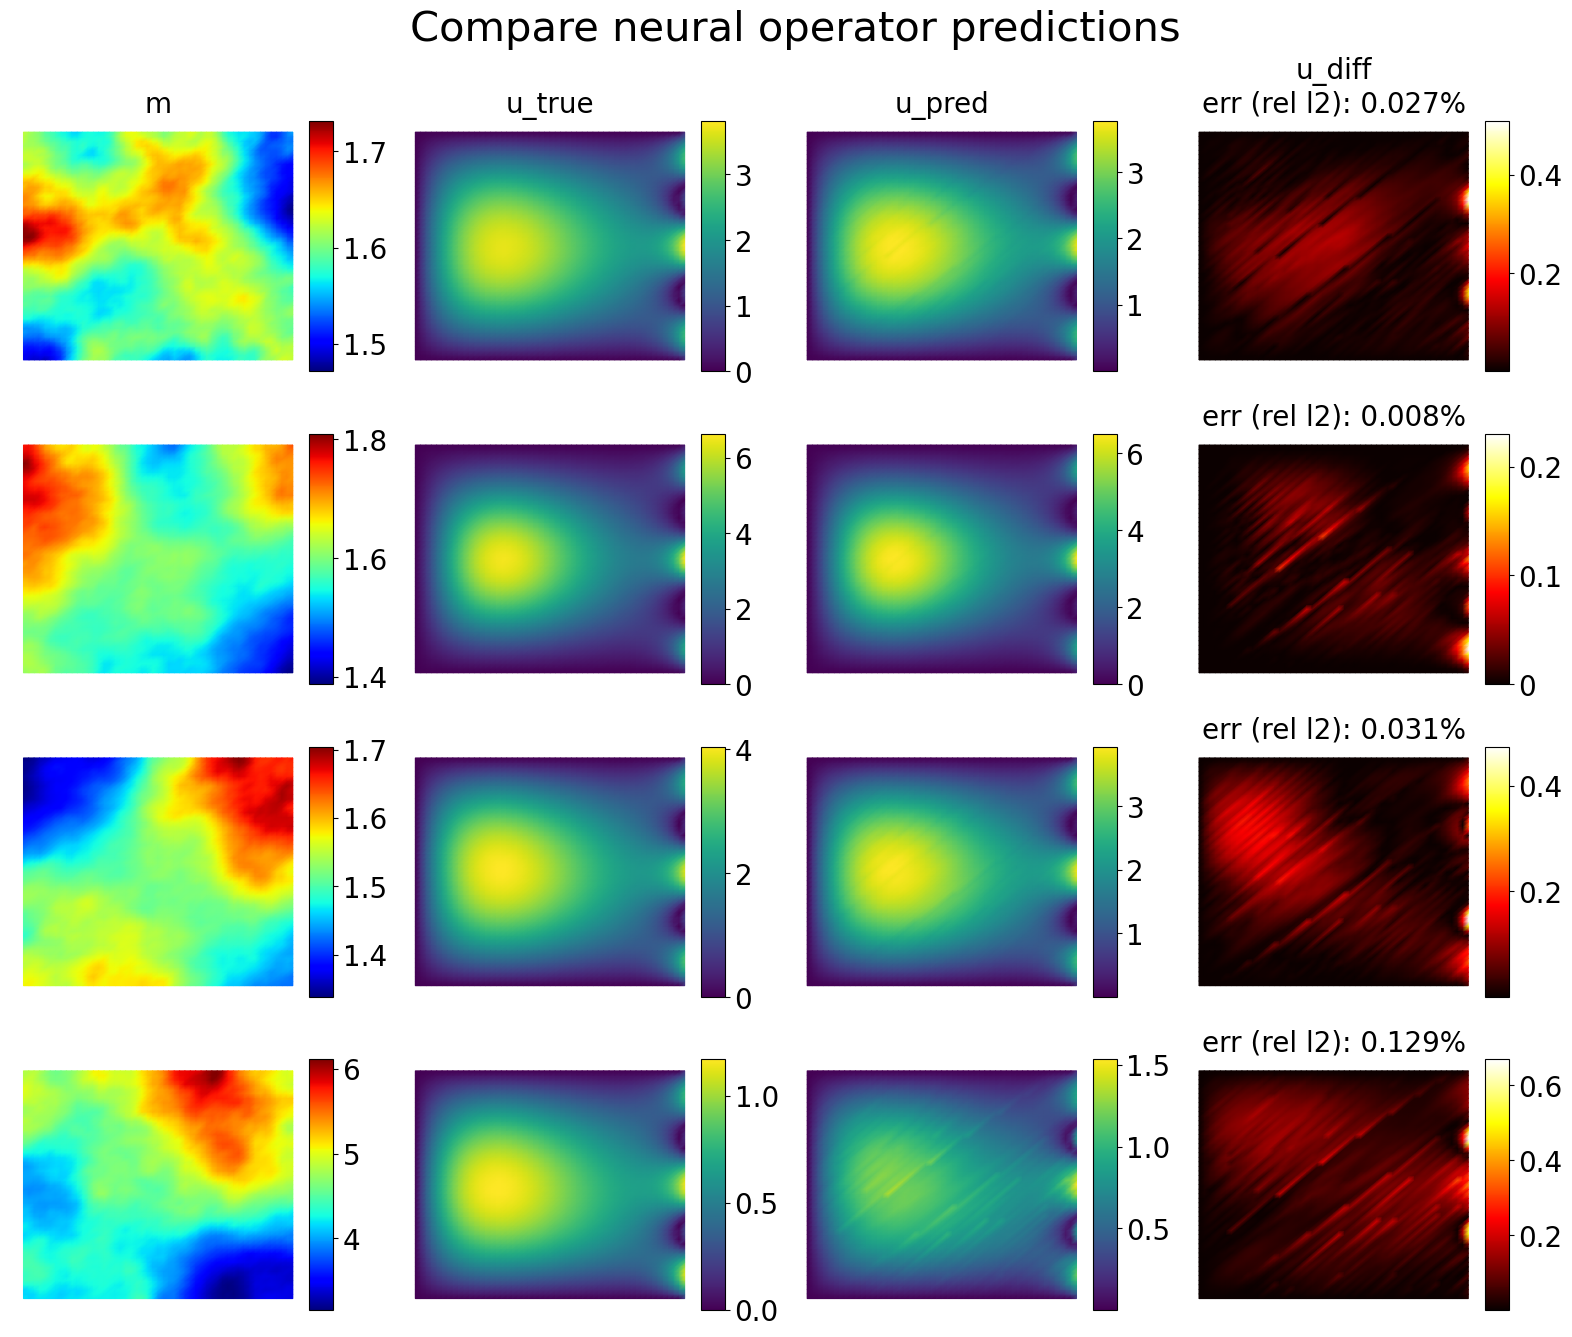

In [17]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + 'Poisson_u_mesh.xdmf')
Vm = get_FE_space(data_folder + 'Poisson_m_mesh.xdmf')

# row: m, u_true, u_pred, u_diff
u_tags = ['m', 'u_true', 'u_pred', 'u_diff']
cmaps = ['jet', 'viridis', 'viridis', 'hot']
Vvec = [Vm, Vu, Vu, Vu]
Y_spatial_points = data.X_trunk # for this problem, nodes are same for m and u functions
X_spatial_points = Y_spatial_points

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot, :, 0]
    i_truth = Y_test[i_plot, :, 0]
    i_m_test = X_test[i_plot, 0, :]
    if decode:
        i_pred = data.decoder_Y_1d(i_pred)
        i_truth = data.decoder_Y_1d(i_truth)
        i_m_test = data.decoder_X_1d(i_m_test)
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        nodes = Y_spatial_points if j > 0 else X_spatial_points
        
        cbar = field_plot_fenics(axs[i,j], uvec[j], Vvec[j], cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()
